In [1]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Dropout, Add, BatchNormalization
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.applications import ResNet50

2025-04-29 23:29:58.835028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745969399.014289      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745969399.067598      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set paths
image_folder = '/kaggle/working/Flicker8k_Dataset'
captions_path = '/kaggle/working/Flickr8k.token.txt'

# Load captions into a dictionary
def load_captions(captions_file):
    captions_dict = {}
    with open(captions_file, 'r') as f:
        for line in f:
            line = line.strip()
            img_id, caption = line.split('\t')
            img_id = img_id.split('#')[0]
            if img_id not in captions_dict:
                captions_dict[img_id] = []
            captions_dict[img_id].append(caption)
    return captions_dict

# Load captions
captions_dict = load_captions(captions_path)



In [4]:
#now extracting the image features using vresnet
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
#restructuring the model (-2 3shan e7na msh 3ayzen el classification elly fel a5er 3ayzen bas n-extract)

#printing the summary of the model we loaded
print(model.summary())

I0000 00:00:1745969411.084530      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745969411.085186      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [5]:
import random

data_features = {}

# Directory containing images
dirc = os.path.join(image_folder)

# List all images in the directory
all_images = os.listdir(dirc)

# Calculate 15% of the total images
num_images_to_select = int(len(all_images) * 1)

# Randomly sample 15% of the images
selected_images = random.sample(all_images, num_images_to_select)

for img_name in tqdm(selected_images):
    filename = os.path.join(dirc, img_name)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocessing the images to input into the model
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]

    data_features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1745969416.824207      97 service.cc:148] XLA service 0x7ac248002db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745969416.825019      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745969416.825040      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745969417.480627      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745969419.988563      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
# store the features extracted 3shan msh kol marra y-extract
pickle.dump(data_features, open('features.pkl', 'wb'))

In [7]:
#loading the features mn el pickle just to make sure
with open('features.pkl', 'rb') as File:
    data_features = pickle.load(File)

In [8]:
mapping ={}

#processing lines:
for line in tqdm(open(captions_path, 'r')):
  tokens = line.split()
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  image_id = image_id.split('.')[0]
  caption = " ".join(caption)

  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)



len(mapping)


0it [00:00, ?it/s]

8092

In [9]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
import re
#preprocessing the text data
def cleanCaptions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = re.sub(r'[^a-z\s]', '', caption)  # Keep only letters and spaces
            caption = re.sub(r'\s+', ' ', caption)       # Replace multiple spaces with single space
            caption = caption.strip()                   # Remove leading/trailing spaces
            caption = '<start> ' + caption + ' <end>'
            captions[i] = caption

# Call cleanCaptions again after fixing
cleanCaptions(mapping)


In [12]:
mapping['1000268201_693b08cb0e']

['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>',
 '<start> a girl going into a wooden building <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a little girl climbing the stairs to her playhouse <end>',
 '<start> a little girl in a pink dress going into a wooden cabin <end>']

In [13]:
captions = []
for key in mapping:
  for caption in mapping[key]:
    captions.append(caption)

len(captions)

40460

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
Vocab = len(tokenizer.word_index) + 1

print(Vocab)

8779


In [15]:
max_len = max(len(caption.split()) for caption in captions)
print(f'Max caption length: {max_len}')

Max caption length: 37


In [16]:
img_ids = list(mapping.keys())
split = int(len(img_ids)*0.80)

train = img_ids[:split]
test = img_ids[split:]

In [17]:
#3shan el session may7slhash crash bne-process el data seq by seq
def generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            captions = mapping.get(key, [])  # get captions wel default to empty list if missing
            image_feature = features.get(key)  #  get features for the image
            if image_feature is None:  # Skip if the feature is missing
                continue
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(image_feature[0])  # Use the feature for the image
                    X2.append(in_seq)
                    y.append(out_seq)
            n += 1
            if n == batch_size:
                X1 = tf.convert_to_tensor(np.array(X1), dtype=tf.float32)  # Image features: (batch_size, 4096)
                X2 = tf.convert_to_tensor(np.array(X2), dtype=tf.int32)    # Sequence data: (batch_size, max_len)
                y = tf.convert_to_tensor(np.array(y), dtype=tf.float32)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0



In [18]:
def create_gru_model(Vocab, max_len, embedding_dim=256, gru_units=256, dropout_rate=0.4):
    # Encoder (Image Feature Processor)
    image_input = Input(shape=(2048,))
    
    # Process image features to match GRU hidden state dimensions
    img_features = Dense(gru_units, activation='relu')(image_input)
    img_features = BatchNormalization()(img_features)
    img_features = Dropout(dropout_rate)(img_features)
    
    # Decoder (Caption Generation)
    caption_input = Input(shape=(max_len,))
    
    # Embedding layer
    caption_embedding = Embedding(
        input_dim=Vocab,
        output_dim=embedding_dim,
        mask_zero=True
    )(caption_input)
    caption_embedding = Dropout(dropout_rate)(caption_embedding)
    
    # GRU layer - using image features as initial state
    gru_layer = GRU(gru_units, return_sequences=False)
    decoder_output = gru_layer(caption_embedding, initial_state=img_features)
    
    # Output layer
    outputs = Dense(Vocab, activation='softmax')(decoder_output)
    
    # Create model
    model = Model(inputs=[image_input, caption_input], outputs=outputs)
    
    # Optimizer
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model

# Create the model
model = create_gru_model(Vocab, max_len)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

# Callbacks for training
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint(
        'best_gru_caption_model.keras',
        monitor='val_loss',
        save_best_only=True
    )
]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 37)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 37, 256)        │      2,247,424 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256)            │          1,024 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 37, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 256)            │        394,752 │ dropout_1[0][0],       │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 8779)           │      2,256,203 │ gru[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,423,947 (20.69 MB)

 Trainable params: 5,423,435 (20.69 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 102s 479ms/step - accuracy: 0.1361 - loss: 6.0646 - val_accuracy: 0.2374 - val_loss: 4.7453
Epoch 2/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 94s 468ms/step - accuracy: 0.2614 - loss: 4.4441 - val_accuracy: 0.3067 - val_loss: 4.0372
Epoch 3/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 95s 472ms/step - accuracy: 0.3152 - loss: 3.8971 - val_accuracy: 0.3298 - val_loss: 3.7527
Epoch 4/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 96s 476ms/step - accuracy: 0.3363 - loss: 3.6263 - val_accuracy: 0.3457 - val_loss: 3.5690
Epoch 5/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 94s 467ms/step - accuracy: 0.3523 - loss: 3.4342 - val_accuracy: 0.3596 - val_loss: 3.4500
Epoch 6/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 84s 419ms/step - accuracy: 0.3661 - loss: 3.2861 - val_accuracy: 0.3672 - val_loss: 3.3669
Epoch 7/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 88s 438ms/step - accuracy: 0.3762 - loss: 3.1715 - val_accuracy: 0.3715 - val_loss: 3.3057
Epoch 8/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 87s 434ms/step - accuracy: 0.3845 - loss: 

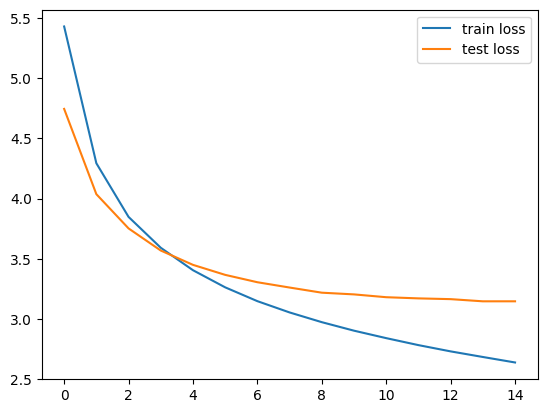

In [19]:
# Define the number of training steps per epoch and validation steps
batch_size = 32
steps = len(train) // batch_size
val_steps = len(test) // batch_size

# Create data generators for training and testing
train_generator = generator(train, mapping, data_features, tokenizer, max_len, Vocab, batch_size)
test_generator = generator(test, mapping, data_features, tokenizer, max_len, Vocab, batch_size)

# Train the model
epochs = 15
history = model.fit(
    train_generator,
    steps_per_epoch=steps,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=val_steps
)

# Plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [20]:
# Save final model
model.save('final_caption_model resnet.h5')
print("✅ Final model saved as 'final_caption_model resnet.h5'")


✅ Final model saved as 'final_caption_model resnet.h5'


In [21]:
from keras.models import load_model
modell = load_model('final_caption_model resnet.h5')
modell.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 37)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 37, 256)        │      2,247,424 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256)            │          1,024 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 37, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 256)            │        394,752 │ dropout_1[0][0],       │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 8779)           │      2,256,203 │ gru[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,423,949 (20.69 MB)

 Trainable params: 5,423,435 (20.69 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 2 (12.00 B)

In [25]:
def predict_caption(model, image_features, tokenizer, max_len):
    """
    Generate a caption for the given image features using the trained model.
    
    Args:
        model: The trained captioning model
        image_features: Extracted features from resnet50 (shape: (1, 4096))
        tokenizer: The tokenizer used during training
        max_len: Maximum length of captions
        
    Returns:
        str: Generated caption
    """
    # Start with the initial token
    in_text = '<start>'
    
    # Iterate until we predict the end token or reach max length
    for _ in range(max_len):
        # Convert current text to sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        # Predict next word
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get index with highest probability
        yhat = np.argmax(yhat)
        
        # Convert index to word
        word = tokenizer.index_word.get(yhat, '')

        # Stop if we predict the end token or if word is empty
        if word == '<end>' or not word:
            break

        # Append word to current text
        in_text += ' ' + word
    
    # Remove start token from final output and any trailing end tokens
    final_caption = in_text.replace('<start>', '').strip()
    final_caption = final_caption.split('<end>')[0].strip()  # Take everything before first <end>
    return final_caption


def generate_caption(image_path, model, resnet_model, tokenizer, max_len):
    """
    Generate caption for an image at the given path.
    
    Args:
        image_path: Path to the image file
        model: Trained captioning model
        resnet_model: ResNet50 model for feature extraction
        tokenizer: Tokenizer used during training
        max_len: Maximum caption length
        
    Returns:
        str: Generated caption
    """
    # Load and preprocess image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    # Extract features using ResNet50
    image_features = resnet_model.predict(image, verbose=0)  # shape (1, 2048)

    # Predict caption
    caption = predict_caption(model, image_features, tokenizer, max_len)
    return caption

In [26]:
import re

def clean_caption(caption):
    # Remove special tokens
    caption = caption.replace('<start>', '').replace('<end>', '')
    caption = ' '.join(caption.split())

    # Remove repeated 'end' words at the end (if not tokenized properly)
    caption = re.sub(r'(end\s*)+$', '', caption, flags=re.IGNORECASE)

    # Capitalize first letter
    if caption:
        caption = caption[0].upper() + caption[1:]

    # Add period if missing
    if caption and not caption.endswith(('.', '!', '?')):
        caption += '.'

    return caption

Generated Caption: A brown dog is playing with a toy in the air .


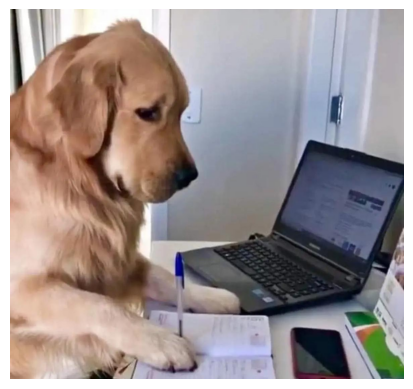

In [27]:
# Example usage:
image_path = '/kaggle/input/infereing/WhatsApp Image 2025-04-28 at 23.35.54_e608d838.jpg'

# First, recreate the resnet50 feature extractor model (the same one you used during training)
resnet_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

# Generate caption
caption = generate_caption(
    image_path=image_path,
    model=model,  # your trained GRU captioning model
    resnet_model=resnet_model,  # the resnet50 feature extractor
    tokenizer=tokenizer,
    max_len=max_len
)
caption = clean_caption(caption)
# Display results
print("Generated Caption:", caption)
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

Generated Caption: A white dog running through a field .


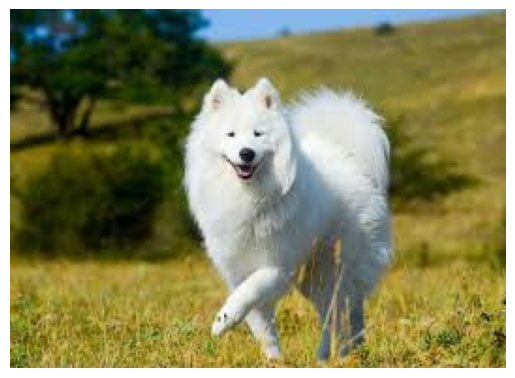

In [29]:
# Example usage:
image_path = '/kaggle/input/infereing/WhatsApp Image 2025-04-30 at 02.34.44_f9b9d74d.jpg'

# First, recreate the resnet50 feature extractor model (the same one you used during training)
resnet_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

# Generate caption
caption = generate_caption(
    image_path=image_path,
    model=model,  # your trained GRU captioning model
    resnet_model=resnet_model,  # the resnet50 feature extractor
    tokenizer=tokenizer,
    max_len=max_len
)
caption = clean_caption(caption)
# Display results
print("Generated Caption:", caption)
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

Generated Caption: A group of people in a field .


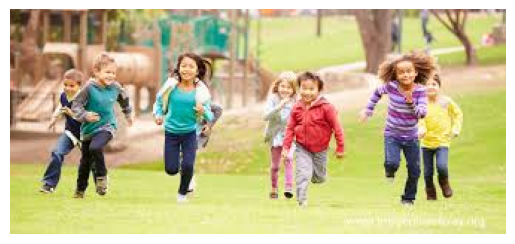

In [31]:
# Example usage:
image_path = '/kaggle/input/infereing/WhatsApp Image 2025-04-30 at 02.34.43_0bb6ec7b.jpg'

# First, recreate the resnet50 feature extractor model (the same one you used during training)
resnet_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

# Generate caption
caption = generate_caption(
    image_path=image_path,
    model=model,  # your trained GRU captioning model
    resnet_model=resnet_model,  # the resnet50 feature extractor
    tokenizer=tokenizer,
    max_len=max_len
)
caption = clean_caption(caption)
# Display results
print("Generated Caption:", caption)
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

Generated Caption: A young boy in a red uniform is running in a field .


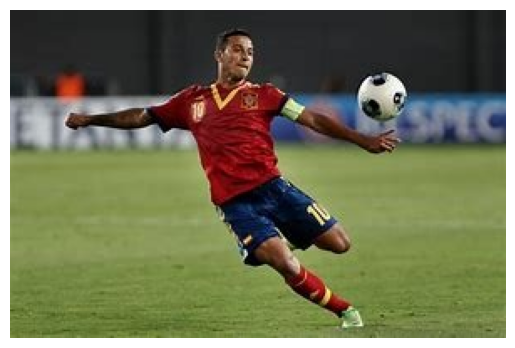

In [32]:
# Example usage:
image_path = '/kaggle/input/infereing/WhatsApp Image 2025-04-29 at 00.07.43_7e9c0b91.jpg'

# First, recreate the resnet50 feature extractor model (the same one you used during training)
resnet_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

# Generate caption
caption = generate_caption(
    image_path=image_path,
    model=model,  # your trained GRU captioning model
    resnet_model=resnet_model,  # the resnet50 feature extractor
    tokenizer=tokenizer,
    max_len=max_len
)
caption = clean_caption(caption)
# Display results
print("Generated Caption:", caption)
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

Generated Caption: A group of people are standing in front of a brick building .


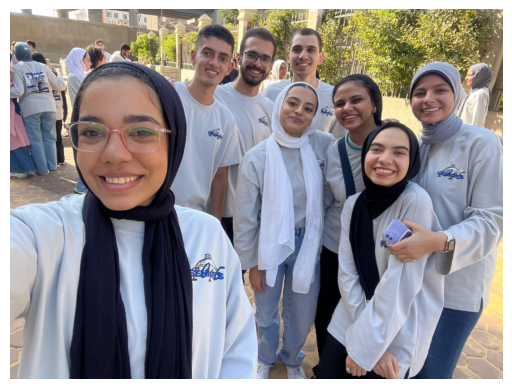

In [42]:
# Example usage:
image_path = '/kaggle/input/infereing/WhatsApp Image 2025-04-30 at 04.03.10_16d15877.jpg'

# First, recreate the resnet50 feature extractor model (the same one you used during training)
resnet_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

# Generate caption
caption = generate_caption(
    image_path=image_path,
    model=model,  # your trained GRU captioning model
    resnet_model=resnet_model,  # the resnet50 feature extractor
    tokenizer=tokenizer,
    max_len=max_len
)
caption = clean_caption(caption)
# Display results
print("Generated Caption:", caption)
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()